理论期权价格: 10.4506

对冲间隔: 1周, 步数: 52
GBM - 标准差比率: 0.8869
二叉树 - 标准差比率: 0.9679

对冲间隔: 2周, 步数: 26
GBM - 标准差比率: 0.8014
二叉树 - 标准差比率: 0.8978

对冲间隔: 4周, 步数: 13
GBM - 标准差比率: 0.7586
二叉树 - 标准差比率: 0.7805

对冲间隔: 13周, 步数: 4
GBM - 标准差比率: 0.7770
二叉树 - 标准差比率: 0.6498

对冲间隔: 26周, 步数: 2
GBM - 标准差比率: 0.8148
二叉树 - 标准差比率: 0.6126

对冲间隔: 52周, 步数: 1
GBM - 标准差比率: 0.8542
二叉树 - 标准差比率: 0.8375


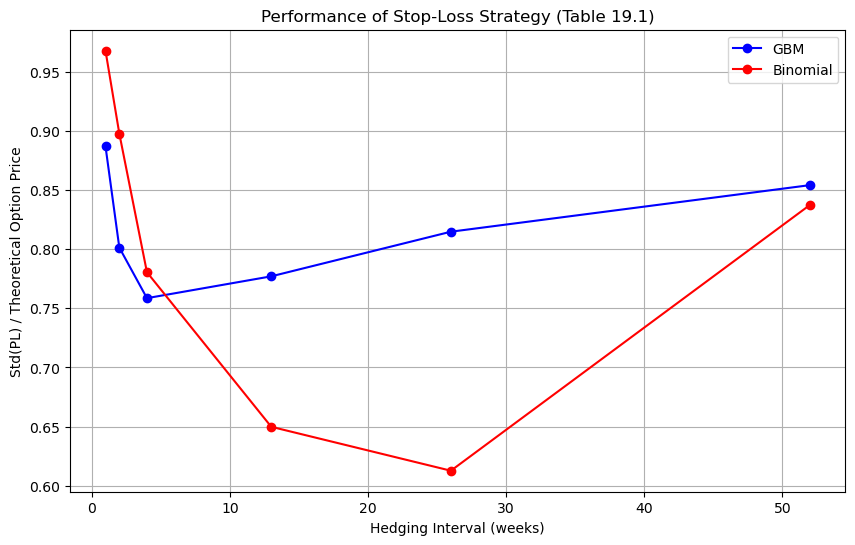

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 设置随机种子以确保可重复性
np.random.seed(42)

# 参数设置
S0 = 100                 # 初始标的资产价格
K = 100                  # 期权执行价（平价期权）
T = 1.0                  # 期权期限（年）
r = 0.05                 # 无风险利率
sigma = 0.2              # 波动率
c = 0.01                 # 交易成本率（每次交易的比例）
N_paths = 1000000          # 模拟路径数
weeks_per_year = 52      # 一年52周
n_values = [1, 2, 4, 13, 26, 52]  # 对冲间隔周数

# 计算理论期权价格（Black-Scholes公式）
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# 生成几何布朗运动（GBM）路径
def generate_gbm_paths(S0, T, r, sigma, n_steps, n_paths):
    dt = T / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    for i in range(n_steps):
        z = np.random.standard_normal(n_paths)
        paths[:, i + 1] = paths[:, i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return paths

# 生成二叉树模型路径
def generate_binomial_paths(S0, T, r, sigma, n_steps, n_paths):
    dt = T / n_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    for i in range(n_steps):
        random_values = np.random.rand(n_paths)
        up_move = random_values < p
        paths[up_move, i + 1] = paths[up_move, i] * u
        paths[~up_move, i + 1] = paths[~up_move, i] * d
    return paths

# 止损策略实现
def stop_loss_hedge(paths, K, cost_rate, n_steps):
    n_paths = paths.shape[0]
    PL_list = []
    # 计算理论期权价格
    BS_price = bs_call_price(S0, K, T, r, sigma)
    for i in range(n_paths):
        S_path = paths[i, :]
        cash = BS_price  # 初始现金为期权价格
        stock_holding = 0  # 股票头寸，0表示无持仓，1表示持有1股
        # 初始头寸设置
        if S_path[0] >= K:
            cash -= S_path[0] * (1 + cost_rate)  # 买入股票，支付交易成本
            stock_holding = 1
        # 遍历每个时间点（到期前）
        for j in range(1, n_steps):
            S_curr = S_path[j]
            if stock_holding == 0 and S_curr >= K:
                # 买入股票
                cash -= S_curr * (1 + cost_rate)
                stock_holding = 1
            elif stock_holding == 1 and S_curr < K:
                # 卖出股票
                cash += S_curr * (1 - cost_rate)
                stock_holding = 0
        # 到期日处理
        S_T = S_path[-1]
        if stock_holding == 1:
            cash += S_T * (1 - cost_rate)  # 卖出股票
        option_payoff = max(S_T - K, 0)  # 期权支付
        cash -= option_payoff
        PL = cash  # 损益为最终现金
        PL_list.append(PL)
    return np.array(PL_list)

# 计算止损策略的表现
def analyze_stop_loss():
    BS_price = bs_call_price(S0, K, T, r, sigma)
    results_gbm = {}
    results_binomial = {}
    for n in n_values:
        steps = weeks_per_year // n  # 总步数
        if steps == 0:
            continue
        print(f"\n对冲间隔: {n}周, 步数: {steps}")
        # GBM路径
        paths_gbm = generate_gbm_paths(S0, T, r, sigma, steps, N_paths)
        PL_gbm = stop_loss_hedge(paths_gbm, K, c, steps)
        std_ratio_gbm = np.std(PL_gbm) / BS_price
        results_gbm[n] = std_ratio_gbm
        print(f"GBM - 标准差比率: {std_ratio_gbm:.4f}")
        # 二叉树路径
        paths_binomial = generate_binomial_paths(S0, T, r, sigma, steps, N_paths)
        PL_binomial = stop_loss_hedge(paths_binomial, K, c, steps)
        std_ratio_binomial = np.std(PL_binomial) / BS_price
        results_binomial[n] = std_ratio_binomial
        print(f"二叉树 - 标准差比率: {std_ratio_binomial:.4f}")
    return results_gbm, results_binomial

# 主程序
if __name__ == "__main__":
    BS_price = bs_call_price(S0, K, T, r, sigma)
    print(f"理论期权价格: {BS_price:.4f}")
    results_gbm, results_binomial = analyze_stop_loss()
    
    # 绘制结果
    n_list = list(results_gbm.keys())
    gbm_ratios = [results_gbm[n] for n in n_list]
    bin_ratios = [results_binomial[n] for n in n_list]
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_list, gbm_ratios, 'bo-', label='GBM')
    plt.plot(n_list, bin_ratios, 'ro-', label='Binomial')
    plt.xlabel('Hedging Interval (weeks)')
    plt.ylabel('Std(PL) / Theoretical Option Price')
    plt.title('Performance of Stop-Loss Strategy (Table 19.1)')
    plt.legend()
    plt.grid(True)
    plt.show()